In [1]:
using FileIO
using CSV
using DataFrames
using LinearAlgebra
using Statistics
using Glob
using Parameters
using Plots

┌ Info: Precompiling Glob [c27321d9-0574-5035-807b-f59d2c89b15c]
└ @ Base loading.jl:1192


In [2]:
@with_kw mutable struct ScenarioResult 
    filename::String = "filename"
    algorithm::String = "algorithm"
    policy::String = "policy"
    collision_cost::Float64 = 0.
    probability_pedestrian_birth::Float64 = 0.
    action_lon_cost::Float64 = 0.
    action_lat_cost::Float64 = 0.
    keep_velocity_reward::Float64 = 0.
    keep_lane_reward::Float64 = 0.
    
    sum_scenarios::Int = 0
    sum_collisions::Int = 0
    sum_emergency_brake_interventions::Int = 0
    dv::Float64 = 0.
    v_mean::Float64 = 0.
    a_mean::Float64 = 0.
    a_jerk::Float64 = 0.
    a_min::Float64 = 0.
end


function evaluate_file(filename)
    
    result = ScenarioResult()
    result.filename = filename
    file_name_parameters = split(filename,'_')
    collision_cost = 0.
    probability_pedestrian_birth = 0.
    action_lon_cost = 0.
    action_lat_cost = 0.
    keep_velocity_reward = 0.
    if ( file_name_parameters[2] != "EmergencyBrakingSystem")    
        if ( file_name_parameters[3] == "EmergencyBrakingSystem")
            result.algorithm = "PedestrianAvoidancePOMDP_EmergencyBrakingSystem" 
            result.policy = file_name_parameters[4]
            result.collision_cost = parse(Float64, file_name_parameters[5])
            result.probability_pedestrian_birth = parse(Float64, file_name_parameters[6])
            result.action_lon_cost = parse(Float64, file_name_parameters[7])
            result.action_lat_cost = parse(Float64, file_name_parameters[8])
            result.keep_velocity_reward = parse(Float64, file_name_parameters[9])
            try
                result.keep_lane_reward = parse(Float64, file_name_parameters[10])
            catch
                
            end
        else
            result.algorithm = "PedestrianAvoidancePOMDP" 
            result.policy = file_name_parameters[3]
            result.collision_cost = parse(Float64, file_name_parameters[4])
            result.probability_pedestrian_birth = parse(Float64, file_name_parameters[5])
            result.action_lon_cost = parse(Float64, file_name_parameters[6])
            result.action_lat_cost = parse(Float64, file_name_parameters[7])
            result.keep_velocity_reward = parse(Float64, file_name_parameters[8])
            try
                result.keep_lane_reward = parse(Float64, file_name_parameters[9])
            catch
                
            end
        end
    else
        result.algorithm = "EmergencyBrakingSystem" 
    end

    dv = []
    v_mean = []
    a_mean = []
    a_jerk = []
    a_min = []

    for row in CSV.File(filename)
        push!(dv, row.v_mean)
        push!(v_mean, row.v_mean)
        push!(a_mean, row.a_mean)
        push!(a_jerk, row.a_jerk)
        push!(a_min, row.a_min)
        result.sum_collisions += row.collision
        result.sum_emergency_brake_interventions += row.eb_intervention
        result.sum_scenarios += 1
    end

    result.dv = mean(dv)
    result.v_mean = mean(v_mean)
    result.a_mean = mean(a_mean)
    result.a_jerk = mean(a_jerk)
    result.a_min = mean(a_min)

    return result
end

evaluate_file (generic function with 1 method)

In [3]:
# get results from Emergency Braking System

files = glob("results_EmergencyBrakingSystem_*.csv")
results = []
for file_name in files
    result = evaluate_file(file_name) 
    push!(results, result)
    println(result)
end

ScenarioResult
  filename: String "results_EmergencyBrakingSystem_no.jld2.csv"
  algorithm: String "EmergencyBrakingSystem"
  policy: String "policy"
  collision_cost: Float64 0.0
  probability_pedestrian_birth: Float64 0.0
  action_lon_cost: Float64 0.0
  action_lat_cost: Float64 0.0
  keep_velocity_reward: Float64 0.0
  keep_lane_reward: Float64 0.0
  sum_scenarios: Int64 26
  sum_collisions: Int64 3
  sum_emergency_brake_interventions: Int64 24
  dv: Float64 12.095090684754608
  v_mean: Float64 12.095090684754608
  a_mean: Float64 -8.655748098055792
  a_jerk: Float64 17.307692307692307
  a_min: Float64 -9.23076923076923



In [4]:
folder_name = "PedestrianAvoidancePOMDP_EmergencyBrakingSystem_lateral"
folder_name = "PedestrianAvoidancePOMDP_lateral"


current_path = pwd()
try
    cd(folder_name)
    files = glob(string("results_", folder_name, "*.csv" ))
    results = []
    for file_name in files
        result = evaluate_file(file_name) 
        push!(results, result)
    end
    
catch
end

cd(current_path)

length(results)

140

In [5]:
probability_pedestrian_birth = 0.3

actionlatcost = [0., -10., -20., -50., -100.]
keeplanereward = [10., 20., 50., 100.]

id_matrix = zeros(Int64, length(actionlatcost), length(keeplanereward))
for i=1:length(results)
    result = results[i]
    if result.probability_pedestrian_birth == probability_pedestrian_birth
        id_action_lon_cost = findall(x->x == result.action_lat_cost, actionlatcost)
        id_keep_velocity_reward = findall(x->x == result.keep_lane_reward, keeplanereward )
        id_matrix[id_action_lon_cost[1],id_keep_velocity_reward[1]] = i 
    end
end
id_matrix

5×4 Array{Int64,2}:
 77  79  80  78
 61  63  64  62
 69  71  72  70
 73  75  76  74
 65  67  68  66

ScenarioResult
  filename: String "results_PedestrianAvoidancePOMDP_lateral2_-600.0_0.3_-1.0_-100.0_20.0_10.0_0.95_.jld2.csv"
  algorithm: String "PedestrianAvoidancePOMDP"
  policy: String "lateral2"
  collision_cost: Float64 -600.0
  probability_pedestrian_birth: Float64 0.3
  action_lon_cost: Float64 -1.0
  action_lat_cost: Float64 -100.0
  keep_velocity_reward: Float64 20.0
  keep_lane_reward: Float64 10.0
  sum_scenarios: Int64 27
  sum_collisions: Int64 0
  sum_emergency_brake_interventions: Int64 0
  dv: Float64 8.407308920949268
  v_mean: Float64 8.407308920949268
  a_mean: Float64 -3.088082576950527
  a_jerk: Float64 40.111111111111114
  a_min: Float64 -3.8518518518518516

keeplanereward: 10.0
collisions: Any[24, 23, 13, 12, 0]
sum_emergency_brake_interventions: Any[0, 0, 0, 0, 0]
[48.142, 47.1841, 41.0796, 39.0122, 30.2663]
----
keeplanereward: 20.0
collisions: Any[22, 14, 13, 11, 1]
sum_emergency_brake_interventions: Any[0, 0, 0, 0, 0]
[47.3273, 43.3189, 40.4555, 38.0476, 32

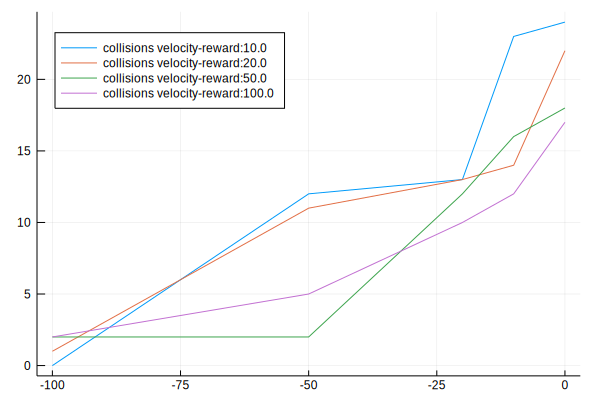

In [7]:
# evaluation based on action lon cost

#println(actionloncost)

plot()


for i = 1:length(keeplanereward)
    sum_collisions = []
    sum_emergency_brake_interventions = []
    dv = []
    v_mean = []
    a_mean = []
    a_jerk = []
    a_min = []
    for id in id_matrix[:,i]
        #println(id)
        push!(sum_collisions, results[id].sum_collisions)
        push!(sum_emergency_brake_interventions, results[id].sum_emergency_brake_interventions)
        push!(dv, results[id].dv)  
        push!(v_mean, results[id].v_mean)
        push!(a_mean, results[id].a_mean)
        push!(a_jerk, results[id].a_jerk)
        push!(a_min, results[id].a_min)
        if ( results[id].v_mean > 8.1 && results[id].sum_collisions == 0 && results[id].sum_emergency_brake_interventions <= 5)
           # println(id)
            println(results[id])
        end
    end
    println("keeplanereward: ", keeplanereward[i])
    println("collisions: ", sum_collisions)
    println("sum_emergency_brake_interventions: ", sum_emergency_brake_interventions)

    println(v_mean*3.6)
    println("----")

     plot!(actionlatcost, sum_collisions, label=string("collisions velocity-reward:", keeplanereward[i]))
  #  plot!(actionlatcost, sum_emergency_brake_interventions, label="#brake_interventions" )
  #  plot!(actionlatcost, a_mean, label="a_mean" )

   # plot!(actionlatcost, a_jerk, label="a_jerk" )
#      plot!(actionlatcost, v_mean*3.6, label=string("v_mean velocity-reward:", keeplanereward[i]))
end

plot!(legend=:topleft)
